In [ ]:
# script to compare different methods of uncertainty estimation

In [1]:
import os
import sys
import pickle
import copy
import numpy as np
import rmgpy.chemkin
import rmgpy
import rmgpy.tools.uncertainty
import rmgpy.kinetics.uncertainties

import random

import rmgpy.kinetics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def reactions_in_same_direction(reactionA, reactionB):
    reactantsA = [x.smiles for x in reactionA.reactants]
    reactantsB = [x.smiles for x in reactionB.reactants]
        
    return reactantsA[0] in reactantsB

In [3]:
def plot_kinetics(rxns, labels=None):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('log10(k)')

    if type(rxns) != list:
        rxns = [rxns]

    T = np.linspace(300, 3000, 1001)
    for rxn in rxns:
        k = np.zeros(len(T))
        for i in range(0, len(T)):
            k[i] = rxn.get_rate_coefficient(T[i], 101325)
        plt.plot(1000.0 / T, np.log10(k))

    if labels:
        plt.legend(labels)
    plt.show()


In [4]:
def get_node_std(rxns, family):
    if len(rxns) == 1:
        print('NO SIDT EST')
        return np.nan
#         return 1.329
    recipe = database.kinetics.families[family].forward_recipe

    rxns = np.array(rxns)

    label = ''
    Tref = 1000.0
    data_mean = np.mean(np.log([r.kinetics.get_rate_coefficient(Tref) for r in rxns]))

    n = len(rxns)

    dlnks = np.array([
        np.log(
            rmgpy.kinetics.arrhenius.ArrheniusBM().fit_to_reactions(rxns[list(set(range(len(rxns))) - {i})], recipe=recipe.actions)
            .to_arrhenius(rxn.get_enthalpy_of_reaction(Tref))
            .get_rate_coefficient(T=Tref) / rxn.get_rate_coefficient(T=Tref)
        ) for i, rxn in enumerate(rxns)
    ])


    varis = (np.array([rmgpy.kinetics.uncertainties.rank_accuracy_map[rxn.rank].value_si for rxn in rxns]) / (2.0 * 8.314 * Tref)) ** 2
    # weighted average calculations
    ws = 1.0 / varis
    V1 = ws.sum()
    V2 = (ws ** 2).sum()
    mu = np.dot(ws, dlnks) / V1
    s = np.sqrt(np.dot(ws, (dlnks - mu) ** 2) / (V1 - V2 / V1))

    kin_uncertainty = rmgpy.kinetics.uncertainties.RateUncertainty(mu=mu, var=s ** 2, N=n, Tref=Tref, data_mean=data_mean, correlation=label)

    std_dev = kin_uncertainty.get_expected_log_uncertainty() / .398

    return std_dev

## Load database

In [5]:
database = rmgpy.data.rmg.RMGDatabase()

thermo_libraries = [
    'Klippenstein_Glarborg2016',
    'BurkeH2O2',
    'thermo_DFT_CCSDTF12_BAC', 
    'DFT_QCI_thermo',
    'primaryThermoLibrary',
    'primaryNS',
    'NitrogenCurran',
    'NOx2018',
    'FFCM1(-)',
    'SulfurLibrary',
    'SulfurGlarborgH2S',
    'SABIC_aromatics',
]

database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = thermo_libraries,
    transport_libraries = [],
    reaction_libraries = [],
    seed_mechanisms = [],#['BurkeH2O2inN2','ERC-FoundationFuelv0.9'],
    kinetics_families = 'all',
    kinetics_depositories = ['training'],
    #frequenciesLibraries = self.statmechLibraries,
    depository = False, # Don't bother loading the depository information, as we don't use it
)

In [6]:
# load aramco
aramco_chemkin_file = '/home/moon/autoscience/aramco/chem_annotated.inp'
aramco_dict_file = '/home/moon/autoscience/aramco/species_dictionary.txt'

species_listA, reaction_listA = rmgpy.chemkin.load_chemkin_file(aramco_chemkin_file, aramco_dict_file)


In [7]:
def get_aramco_rxn_i(rxn):
    for i in range(len(reaction_listA)):
        if rxn.is_isomorphic(reaction_listA[i]):
            return i
    return -1

In [8]:
# Load the model

# Must use annotated chemkin file
# chemkin_file = 'RMG-MAX1/chem_annotated.inp'
# dict_file = 'RMG-MAX1/species_dictionary.txt'

# chemkin_file = 'RMG-min-7/chem_annotated.inp'
# dict_file = 'RMG-min-7/species_dictionary.txt'

chemkin_file = 'ethane_original_db/chemkin/chem_annotated.inp'
dict_file = 'ethane_original_db/chemkin/species_dictionary.txt'

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin_file, dict_file)


# Run Gao estimation of input parameters (takes a long time to load database)
uncertainty = rmgpy.tools.uncertainty.Uncertainty(output_directory='uncertainty_calculations')
uncertainty.load_model(chemkin_file, dict_file)


thermo_libs = [
    'primaryThermoLibrary',
]

kinetic_libs = [
]

uncertainty.load_database(
    thermo_libraries=thermo_libs,
    kinetics_families='default',
    reaction_libraries=kinetic_libs,
)
uncertainty.extract_sources_from_model()
uncertainty.assign_parameter_uncertainties()

In [9]:
# Create a giant dictionary with all of the reaction family information in it
auto_gen_families = {}
for family_name in database.kinetics.families.keys():
    if family_name == 'Intra_R_Add_Endocyclic' or family_name == 'Intra_R_Add_Exocyclic':
        continue
    if database.kinetics.families[family_name].auto_generated and family_name not in auto_gen_families.keys():
        auto_gen_families[family_name] = database.kinetics.families[family_name].rules.get_entries()
        auto_gen_families[f'{family_name}_labels'] = [entry.label for entry in database.kinetics.families[family_name].rules.get_entries()]
        auto_gen_families[f'{family_name}_rxn_map'] = database.kinetics.families[family_name].get_reaction_matches(
            thermo_database=database.thermo,
            remove_degeneracy=True,
            get_reverse=True,
            exact_matches_only=False,
            fix_labels=True)


ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.419,128.588,135.2,140.503,147.924,152.211,155.919],'J/(mol*K)'), H298=(19.7155,'kJ/mol'), S298=(387.478,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(153.818,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsClClClCs) + longDistanceInteraction_noncyclic(Cs(Cl)3-Cs(Cl)2) + group(CsCsClClH) + radical(CsCl1sCl1sCs)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for Entropy calculationat T = 2000.0 K...
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([139.592,151.36,159.399,165.718,174.181,178.534,180.476],'J/(mol*K)'), H298=(-162.929,'kJ/mol'), S298=(391.397,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsClClClCs) + longDistanceInteraction_noncyclic(Cs(Cl)3-Cs(Cl)3) + group(CsClClClCs) + longDistanceInteraction_noncyclic(Cs(Cl)3-Cs(Cl)3)""").
The thermo for this species is probabl

# For each reaction, plot the kinetics and uncertainty

0


0.5
Arrhenius(A=(9.45e+14,'cm^3/(mol*s)'), n=-0.538, Ea=(0.135,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 9 CH3 + CH3 <=> C2H6 in R_Recombination/training
This reaction matched rate rule [Root_N-1R->H_N-1CNOS->N_N-1COS->O_1CS->C_N-1C-inRing]
family: R_Recombination""")


1


0.5
Arrhenius(A=(35,'cm^3/(mol*s)'), n=3.44, Ea=(10.384,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 215 C2H6 + CH3_r3 <=> C2H5b + CH4 in H_Abstraction/training
This reaction matched rate rule [C/H3/Cs\H3;C_methyl]
family: H_Abstraction""")


2


0.5
Arrhenius(A=(1e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 58 H + C2H5 <=> C2H6-2 in R_Recombination/training
This reaction matched rate rule [Root_1R->H_N-2R->S_N-2CHNO->H_N-2CNO-inRing_Ext-2CNO-R_N-Sp-3R!H=2CCNNOO_N-2CNO->O_3R!H->C_Sp-3C-2CN]
family: R_Recombination""")


3


0.5
Arrhenius(A=(1.93e+14,'cm^3/(mol*s)'), n=0, Ea=(0.27,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 57 H + CH3 <=> CH4 in R_Recombination/training
This reaction matched rate rule [Root_1R->H_N-2R->S_N-2CHNO->H_N-2CNO-inRing_N-2CNO->O]
family: R_Recombination""")


4


0.5
Arrhenius(A=(4.62e+08,'cm^3/(mol*s)'), n=1.64, Ea=(1.01,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 2541 H + C2H4 <=> C2H5-2 in R_Addition_MultipleBond/training
This reaction matched rate rule [Cds-HH_Cds-HH;HJ]
family: R_Addition_MultipleBond""")


5


0.5
Arrhenius(A=(6.57e+14,'cm^3/(mol*s)'), n=-0.68, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 5 CH3_r1 + C2H5 <=> CH4 + C2H4 in Disproportionation/training
This reaction matched rate rule [Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_4CNS->C_1CNS->C_Sp-2R!H-1C_2R!H->C]
family: Disproportionation""")


6


0.5
Arrhenius(A=(6.9e+13,'cm^3/(mol*s)'), n=-0.35, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 6 C2H5 + C2H5-2 <=> C2H6 + C2H4 in Disproportionation/training
This reaction matched rate rule [Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N- Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O_Sp-5CS-4CCNSS_N-1CNS->S]
family: Disproportionation""")


7


0.5
Arrhenius(A=(1.15e+08,'cm^3/(mol*s)'), n=1.9, Ea=(7.53,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 210 C2H6 + H <=> C2H5b + H2_p in H_Abstraction/training
This reaction matched rate rule [C/H3/Cs\H3;H_rad]
family: H_Abstraction""")


8


0.5
Arrhenius(A=(1.083e+13,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 4 H + C2H5 <=> H2 + C2H4 in Disproportionation/training
This reaction matched rate rule [Root_4R->H_Sp-2R!H-1R!H_2R!H-u1_N-1R!H->O_1CN->C_2R!H->C]
family: Disproportionation""")


9


0.5
Arrhenius(A=(4100,'cm^3/(mol*s)'), n=3.156, Ea=(8.755,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 186 CH4b + H <=> CH3_p1 + H2_p in H_Abstraction/training
This reaction matched rate rule [C_methane;H_rad]
family: H_Abstraction""")


10


0.5
Arrhenius(A=(5.45e+10,'cm^3/(mol*s)'), n=0, Ea=(1.5,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 56 H + H <=> H2 in R_Recombination/training
This reaction matched rate rule [Root_1R->H_N-2R->S_2CHNO->H]
family: R_Recombination""")
REVERSING


11


0.5
Arrhenius(A=(1.21e+14,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 60 H + C2H3 <=> C2H4 in R_Recombination/training
This reaction matched rate rule [Root_1R->H_N-2R->S_N-2CHNO->H_N-2CNO-inRing_Ext-2CNO-R_Sp-3R!H=2CCNNOO_N-3R!H->O]
family: R_Recombination""")


12


0.5
Arrhenius(A=(0.02236,'cm^3/(mol*s)'), n=4.34, Ea=(5.7,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 842 C2H3 + CH4b <=> C2H4 + CH3_p23 in H_Abstraction/training
This reaction matched rate rule [Cd/H2/NonDeC;C_methyl]
family: H_Abstraction""")
REVERSING


13


0.5
Arrhenius(A=(0.00108,'cm^3/(mol*s)'), n=4.55, Ea=(3.5,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 774 C2H3 + C2H6 <=> C2H4 + C2H5 in H_Abstraction/training
This reaction matched rate rule [Cd/H2/NonDeC;C_rad/H2/Cs\H3]
family: H_Abstraction""")


14


0.5
Arrhenius(A=(240,'cm^3/(mol*s)'), n=3.62, Ea=(11.266,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 217 C2H4 + H <=> C2H3_p + H2_p in H_Abstraction/training
This reaction matched rate rule [Cd/H2/NonDeC;H_rad]
family: H_Abstraction""")


15


0.5
Arrhenius(A=(4.56e+14,'cm^3/(mol*s)'), n=-0.7, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 11 C2H3-2 + C2H5 <=> C2H4-2 + C2H4 in Disproportionation/training
This reaction matched rate rule [Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O_N-Sp-5CS-4CCNSS]
family: Disproportionation""")
REVERSING


16


0.5
Arrhenius(A=(1.03e+09,'cm^3/(mol*s)'), n=1.64, Ea=(2.11,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 2697 H + C2H2 <=> C2H3-2 in R_Addition_MultipleBond/training
This reaction matched rate rule [Ct-H_Ct-H;HJ]
family: R_Addition_MultipleBond""")


NO SIDT EST
17


13.593787746348928
Arrhenius(A=(1.62e+06,'cm^3/(mol*s)'), n=1.87, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_4CNS->C_1CNS->C_N-Sp-2R!H-1C
Multiplied by reaction path degeneracy 2.0""")


18


5.174388791161937
Arrhenius(A=(1.7146e+13,'cm^3/(mol*s)'), n=-0.225, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O_Sp-5CS-4CCNSS
Multiplied by reaction path degeneracy 2.0""")


NO SIDT EST
19


13.593787746348928
Arrhenius(A=(4.8e+08,'cm^3/(mol*s)'), n=1.5, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_4R->H_N-Sp-2R!H-1R!H_1R!H->C
Multiplied by reaction path degeneracy 2.0""")


20


5.384559909166189
Arrhenius(A=(2.76872e+13,'cm^3/(mol*s)'), n=-0.304, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O
Multiplied by reaction path degeneracy 2.0""")


21


13.809177173446296
Arrhenius(A=(7.90318e+18,'s^-1'), n=-1.971, Ea=(9.786,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root
Multiplied by reaction path degeneracy 2.0""")


22


0.5
Arrhenius(A=(861,'cm^3/(mol*s)'), n=2.988, Ea=(7.238,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 2902 CH3 + C2H4 <=> C3H7 in R_Addition_MultipleBond/training
This reaction matched rate rule [Cds-HH_Cds-HH;CsJ-HHH]
family: R_Addition_MultipleBond""")


23


0.5
Arrhenius(A=(28600,'cm^3/(mol*s)'), n=2.41, Ea=(1.8,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 234 C2H3 + C2H4 <=> C4H7-3 in R_Addition_MultipleBond/training
This reaction matched rate rule [Cds-HH_Cds-HH;CdsJ-H]
family: R_Addition_MultipleBond""")
REVERSING


24


0.5
Arrhenius(A=(6.32e+08,'s^-1'), n=0.97, Ea=(8.9,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 335 C4H7 <=> C4H7-2 in Intra_R_Add_Exocyclic/training
This reaction matched rate rule [Backbone1_Sp-4R!H=1R!H]
family: Intra_R_Add_Exocyclic""")


25


0.5
Arrhenius(A=(13600,'cm^3/(mol*s)'), n=2.41, Ea=(6.2,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 2254 C2H2 + C2H5 <=> C4H7-6 in R_Addition_MultipleBond/training
This reaction matched rate rule [Ct-H_Ct-H;CsJ-CsHH]
family: R_Addition_MultipleBond""")


26


2.5536049848239344
Arrhenius(A=(111300,'s^-1'), n=2.23, Ea=(10.59,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [R4H_DSS;Cd_rad_out_singleH;Cs_H_out] for rate rule [R4H_DSS;Cd_rad_out_singleH;Cs_H_out_2H]
Euclidian distance = 1.0
Multiplied by reaction path degeneracy 3.0
family: intra_H_migration""")


27


0.5
Arrhenius(A=(1.72e+06,'s^-1'), n=1.99, Ea=(27.2,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 84 C:CC[CH2] <=> C:C[CH]C in intra_H_migration/training
This reaction matched rate rule [R2H_S;C_rad_out_2H;Cs_H_out_H/Cd]
family: intra_H_migration""")
REVERSING


28


0.5
Arrhenius(A=(1.846e+10,'s^-1'), n=0.74, Ea=(34.7,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 194 C4H7-4 <=> C4H7-5 in intra_H_migration/training
This reaction matched rate rule [R3H_DS;Cd_rad_out_singleH;Cs_H_out_H/NonDeC]
family: intra_H_migration""")


29


0.5
Arrhenius(A=(3.615e+13,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 89 C2H3 + C2H3 <=> C4H6-4 in R_Recombination/training
This reaction matched rate rule [Root_N-1R->H_N-1CNOS->N_N-1COS->O_1CS->C_N-1C-inRing_Ext-2R-R_N-Sp-3R!H-2R_N-3R!H->O_N-Sp-3CCSS#2R_Ext-1C-R]
family: R_Recombination""")
REVERSING


30


0.5
Arrhenius(A=(3.24e+08,'cm^3/(mol*s)'), n=1.64, Ea=(2.4,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 2580 H + C4H6-2 <=> C4H7-11 in R_Addition_MultipleBond/training
This reaction matched rate rule [Cds-CdH_Cds-HH;HJ]
family: R_Addition_MultipleBond""")


NO SIDT EST
31


13.593787746348928
Arrhenius(A=(2.3e+13,'cm^3/(mol*s)'), n=-0.32, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_4CHNS->C_4C-u1
Multiplied by reaction path degeneracy 2.0""")


32


2.8448431091001956
Arrhenius(A=(3.7394e+12,'cm^3/(mol*s)'), n=-0.032, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S_N-4CHNS->S_N- Sp-6BrBrBrCCCClClClFFFIIINNNOOOPPPSiSiSi#4C_6BrCClFINOPSi->C_N-1R!H-inRing_Sp-6C-4C
Multiplied by reaction path degeneracy 2.0""")


NO SIDT EST
33


13.593787746348928
Arrhenius(A=(3.62e+12,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_N-4CHNS->C
Multiplied by reaction path degeneracy 2.0""")


NO SIDT EST
34


13.593787746348928
Arrhenius(A=(2.42e+12,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S_N-4CHNS->S_N- Sp-6BrBrBrCCCClClClFFFIIINNNOOOPPPSiSiSi#4C_6BrCClFINOPSi->C_N-1R!H-inRing_N-Sp-6C-4C
Multiplied by reaction path degeneracy 2.0""")


35


0.5
Arrhenius(A=(4.62e+08,'cm^3/(mol*s)'), n=1.64, Ea=(-0.47,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 2544 H + C4H6 <=> C4H7-9 in R_Addition_MultipleBond/training
This reaction matched rate rule [Cds-HH_Cds-CdH;HJ]
family: R_Addition_MultipleBond""")


NO SIDT EST
36


13.593787746348928
Arrhenius(A=(1.5e+11,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-2R!H-R_2R!H->C_4R->C
Multiplied by reaction path degeneracy 3.0""")


NO SIDT EST
37


13.593787746348928
Arrhenius(A=(1.5e+11,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-2R!H-R_2R!H->C_4R->C
Multiplied by reaction path degeneracy 3.0""")


NO SIDT EST
38


13.593787746348928
Arrhenius(A=(2.169e+13,'cm^3/(mol*s)'), n=0, Ea=(3.986,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-2R!H-R_2R!H->C_N-4R->C
Multiplied by reaction path degeneracy 3.0""")


NO SIDT EST
39


13.593787746348928
Arrhenius(A=(1.5e+11,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-2R!H-R_2R!H->C_4R->C
Multiplied by reaction path degeneracy 3.0""")


40


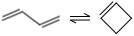

0.5
Arrhenius(A=(6.70652e+13,'s^-1'), n=-0.361, Ea=(44.856,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 1 C4H6_BD <=> C4H6_CB in Intra_2+2_cycloaddition_Cd/training
This reaction matched rate rule [1,3-butadiene_backbone;CdH2_1;CdH2_2]
family: Intra_2+2_cycloaddition_Cd""")


41


4.815436220508818
Arrhenius(A=(3.53274e+13,'cm^3/(mol*s)'), n=0.153, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_1R->H_N-2R->S_N-2CHNO->H_N-2CNO-inRing_Ext-2CNO-R_N-Sp-3R!H=2CCNNOO_N-2CNO->O_Ext-2CN-R
Multiplied by reaction path degeneracy 2.0""")


42


3.1132904828579067
Arrhenius(A=(4.66096e+15,'cm^3/(mol*s)'), n=-0.9, Ea=(1.445,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O_Sp-5CS-4CCNSS_Ext-4CNS-R
Multiplied by reaction path degeneracy 6.0""")


43


5.174388791161937
Arrhenius(A=(3.42919e+13,'cm^3/(mol*s)'), n=-0.225, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O_Sp-5CS-4CCNSS
Multiplied by reaction path degeneracy 4.0""")


NO SIDT EST
44


14.21010715301882
Arrhenius(A=(3.25196e+13,'cm^3/(mol*s)'), n=0.255, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_1R->H_N-2R->S_N-2CHNO->H_N-2CNO-inRing_Ext-2CNO-R_N- Sp-3R!H=2CCNNOO_N-2CNO->O_3R!H->C_Sp-3C-2CN_Ext-3C-R_Sp-4R!H=3C_N-3C-inRing
Multiplied by reaction path degeneracy 2.0""")


NO SIDT EST
45


13.593787746348928
Arrhenius(A=(1.374e+14,'cm^3/(mol*s)'), n=-0.35, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N- Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O_Sp-5CS-4CCNSS_N-1CNS->S_Ext-5CS-R
Multiplied by reaction path degeneracy 6.0""")


46


5.174388791161937
Arrhenius(A=(3.42919e+13,'cm^3/(mol*s)'), n=-0.225, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O_Sp-5CS-4CCNSS
Multiplied by reaction path degeneracy 4.0""")


47


6.427921622500528
Arrhenius(A=(4.2106e+14,'cm^3/(mol*s)'), n=-0.55, Ea=(0.64,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S_N-4CHNS->S_N- Sp-6BrBrBrCCCClClClFFFIIINNNOOOPPPSiSiSi#4C_6BrCClFINOPSi->C_N-1R!H-inRing_Ext-4C-R_N-2R!H->S
Multiplied by reaction path degeneracy 4.0""")


NO SIDT EST
48


13.593787746348928
Arrhenius(A=(3e+11,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-2R!H-R_2R!H->C_4R->C
Multiplied by reaction path degeneracy 6.0""")


NO SIDT EST
49


13.593787746348928
Arrhenius(A=(5.8e+12,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S_N-4CHNS->S_N- Sp-6BrBrBrCCCClClClFFFIIINNNOOOPPPSiSiSi#4C_6BrCClFINOPSi->C_N-1R!H-inRing_Sp-6C-4C_Ext-6C-R
Multiplied by reaction path degeneracy 4.0""")


NO SIDT EST
50


13.593787746348928
Arrhenius(A=(3e+11,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-2R!H-R_2R!H->C_4R->C
Multiplied by reaction path degeneracy 6.0""")


51


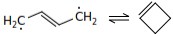

5.453489726588859
Arrhenius(A=(8.69088e+06,'s^-1'), n=1.216, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_1R!H->C""")


52


0.5
Arrhenius(A=(5.01e+07,'s^-1'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 5 C4H6 => C4H6-2 in 1,2-Birad_to_alkene/training
This reaction matched rate rule [Y_12_01]
family: 1,2-Birad_to_alkene""")


53


3.169924391518818
Arrhenius(A=(7.77203e+08,'s^-1'), n=1.395, Ea=(45.95,'kcal/mol'), T0=(1,'K'), comment="""Estimated using template [R3H_SS;C_rad_out_H/NonDeC;Cs_H_out_2H] for rate rule [R3H_SS_12cy3;C_rad_out_H/NonDeC;Cs_H_out_2H]
Euclidian distance = 1.0
Multiplied by reaction path degeneracy 3.0
family: intra_H_migration""")


54


13.593787746348928
Arrhenius(A=(3.68393e+12,'s^-1'), n=-0.105, Ea=(35.881,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Backbone0_N-2R!H-inRing_N-1R!H-inRing_Sp-2R!H-1R!H_Ext-3R!H-R_Sp-3R!H=1R!H""")


55


0.5
Arrhenius(A=(5.46e+08,'cm^3/(mol*s)'), n=1.64, Ea=(3.78,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 2714 H + C4H6-4 <=> C4H7-13 in R_Addition_MultipleBond/training
This reaction matched rate rule [Ca_Cds-HH;HJ]
family: R_Addition_MultipleBond""")


56


9.314786885541315
Arrhenius(A=(3.80674e+08,'cm^3/(mol*s)'), n=1.065, Ea=(3.229,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_Sp-5R!H=1R!H""")


NO SIDT EST
57


13.593787746348928
Arrhenius(A=(9.64e+11,'cm^3/(mol*s)'), n=0, Ea=(6.652,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_Sp-5R!H=1R!H_Ext-4CHNS-R_Sp-6R!H-4CHNS""")


58


23.488111132597588
Arrhenius(A=(8.86839e+08,'cm^3/(mol*s)'), n=0.871, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O""")


NO SIDT EST
59


13.593787746348928
Arrhenius(A=(2.41e+12,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_Sp-5R!H=1R!H_Ext-4CHNS-R_N-Sp-6R!H-4CHNS""")


60


2.5536049848239344
Arrhenius(A=(1.4874e+09,'s^-1'), n=1.045, Ea=(15.153,'kcal/mol'), T0=(1,'K'), comment="""Estimated using an average for rate rule [R3radExo;Y_rad;XH_Rrad]
Euclidian distance = 0
Multiplied by reaction path degeneracy 2.0
family: Intra_Disproportionation""")


NO SIDT EST
61


13.593787746348928
Arrhenius(A=(1.686e+11,'cm^3/(mol*s)'), n=0, Ea=(6.982,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_Sp-5R!H=1R!H_Ext-4CHNS-R_Ext-6R!H-R
Multiplied by reaction path degeneracy 2.0""")


NO SIDT EST
62


13.593787746348928
Arrhenius(A=(1.686e+11,'cm^3/(mol*s)'), n=0, Ea=(12.469,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_Sp-5R!H=1R!H_Ext-4CHNS-R_Ext-6R!H-R
Multiplied by reaction path degeneracy 2.0""")


63


0.5
Arrhenius(A=(1.168e+07,'cm^3/(mol*s)'), n=1.997, Ea=(5.452,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 196 C2H2 + C2H3 <=> C4H5-8 in R_Addition_MultipleBond/training
This reaction matched rate rule [Ct-H_Ct-H;CdsJ-H]
family: R_Addition_MultipleBond""")


64


9.806055413138818
Arrhenius(A=(8.15666e+18,'cm^3/(mol*s)'), n=-1.493, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_1R->H_N-2R->S_N-2CHNO->H_N-2CNO-inRing_Ext-2CNO-R_Sp-3R!H=2CCNNOO_N-3R!H->O""")


65


1.5
Arrhenius(A=(0.03432,'cm^3/(mol*s)'), n=4.34, Ea=(20.71,'kcal/mol'), T0=(1,'K'), comment="""From training reaction 1566 used for Cd/H2/NonDeC;C_methyl
Exact match found for rate rule [Cd/H2/NonDeC;C_methyl]
Euclidian distance = 0
Multiplied by reaction path degeneracy 4.0
family: H_Abstraction""")


66


1.5
Arrhenius(A=(632,'cm^3/(mol*s)'), n=3.13, Ea=(18,'kcal/mol'), T0=(1,'K'), comment="""From training reaction 343 used for Cd/H2/NonDeC;C_rad/H2/Cs\H3
Exact match found for rate rule [Cd/H2/NonDeC;C_rad/H2/Cs\H3]
Euclidian distance = 0
Multiplied by reaction path degeneracy 4.0
family: H_Abstraction""")


67


1.5
Arrhenius(A=(240,'cm^3/(mol*s)'), n=3.62, Ea=(11.266,'kcal/mol'), T0=(1,'K'), comment="""From training reaction 217 used for Cd/H2/NonDeC;H_rad
Exact match found for rate rule [Cd/H2/NonDeC;H_rad]
Euclidian distance = 0
Multiplied by reaction path degeneracy 4.0
family: H_Abstraction""")


NO SIDT EST
68


13.593787746348928
Arrhenius(A=(4.56e+14,'cm^3/(mol*s)'), n=-0.7, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O_N-Sp-5CS-4CCNSS
Multiplied by reaction path degeneracy 3.0""")


69


0.5
Arrhenius(A=(0.0003437,'cm^3/(mol*s)'), n=4.732, Ea=(6.579,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 177 C4H6-3 + C2H3 <=> C2H4 + C4H5 in H_Abstraction/training
This reaction matched rate rule [Cd/H2/NonDeC;Cd_Cd\H2_pri_rad]
family: H_Abstraction""")


70


5.384559909166189
Arrhenius(A=(2.76872e+13,'cm^3/(mol*s)'), n=-0.304, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O
Multiplied by reaction path degeneracy 2.0""")


NO SIDT EST
71


13.593787746348928
Arrhenius(A=(2.42e+12,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_N-Sp-5R!H=1R!H_Ext-4CHNS-R_N-6R!H->S_N-4CHNS->S_N- Sp-6BrBrBrCCCClClClFFFIIINNNOOOPPPSiSiSi#4C_6BrCClFINOPSi->C_N-1R!H-inRing_N-Sp-6C-4C
Multiplied by reaction path degeneracy 2.0""")


NO SIDT EST
72


13.593787746348928
Arrhenius(A=(1.5e+11,'cm^3/(mol*s)'), n=0, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-2R!H-R_2R!H->C_4R->C
Multiplied by reaction path degeneracy 3.0""")


NO SIDT EST
73


13.593787746348928
Arrhenius(A=(8.43e+10,'cm^3/(mol*s)'), n=0, Ea=(2.13,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_Ext-1R!H-R_N-4R->O_Sp-5R!H=1R!H_Ext-4CHNS-R_Ext-6R!H-R""")


74


0.5
Arrhenius(A=(133800,'cm^3/(mol*s)'), n=2.41, Ea=(6.77,'kcal/mol'), T0=(1,'K'), comment="""Matched reaction 2253 C2H2 + CH3 <=> C3H5-2 in R_Addition_MultipleBond/training
This reaction matched rate rule [Ct-H_Ct-H;CsJ-HHH]
family: R_Addition_MultipleBond""")




In [10]:
# Plot BM node variance uncertainty, Gao uncertainty, 
# aramco equation?
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# for i in [0, 10, 20]:
for i in range(len(uncertainty.reaction_list)):
    # Plot kinetics
    Tref = 1000.0
    T = np.linspace(300, 3000, 1001)
    P = 101325
    k = np.zeros(len(T))
    plt.clf()
    for j in range(0, len(T)):
        k[j] = uncertainty.reaction_list[i].get_rate_coefficient(T[j])
    plt.plot(1000.0 / T, k, label=f'R{i}', color=colors[1], alpha=0.7)

    
    gao_sigma_lnk = uncertainty.kinetic_input_uncertainties[i]
    gao_sigma_k = np.exp(gao_sigma_lnk)


    # Plot node std dev
    plt.fill_between(1000.0 / T, k, k * gao_sigma_k, alpha=0.5, color=colors[1], edgecolor=None, label='Gao std dev')
    plt.fill_between(1000.0 / T, k / gao_sigma_k, k, alpha=0.5, color=colors[1], edgecolor=None)

    # plot Matt's uncertainty if it's a BM tree node...
    if 'Rate Rules' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys() and \
            uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['node']:
        family = uncertainty.reaction_list[i].family
        if family != 'Intra_R_Add_Endocyclic' and family != 'Intra_R_Add_Exocyclic':
            node = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['node']
            rxns = auto_gen_families[f'{family}_rxn_map'][node]
#             sigma_lnk = get_node_std(rxns, family)
            if len(rxns) == 1:
                print('NO SIDT EST')
            sigma_lnk = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['node_std_dev']
            
            if np.isnan(sigma_lnk):
                continue
            sigma_k = np.exp(sigma_lnk)
            plt.fill_between(1000.0 / T, k, k * sigma_k, alpha=0.5, color=colors[2], edgecolor=None, label='Matt SIDT std dev')
            plt.fill_between(1000.0 / T, k / sigma_k, k, alpha=0.5, color=colors[2], edgecolor=None)
        
        
            # also plot training reactions
            for z in range(len(auto_gen_families[f'{family}_rxn_map'][node])):
                rxn = auto_gen_families[f'{family}_rxn_map'][node][z]
                k = np.zeros(len(T))
                for j in range(0, len(T)):
                    assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
                    k[j] = rxn.get_rate_coefficient(T[j])
                if z == 0:
                    plt.plot(1000.0 / T, k, label='Training Reactions', color=colors[0], alpha=0.5)
                else:
                    plt.plot(1000.0 / T, k, label='_nolegend_', color=colors[0], alpha=0.5)
                plt.yscale('log')
        
    print(i)
    display(uncertainty.reaction_list[i])
    print(uncertainty.kinetic_input_uncertainties[i])
    print(uncertainty.reaction_list[i].kinetics)
        
    # look for Aramco version
    a = get_aramco_rxn_i(uncertainty.reaction_list[i])
    P = 101325
    if a >= 0:
        # reverse the reaction if need be:
        rxnA = reaction_listA[a]
        if not reactions_in_same_direction(uncertainty.reaction_list[i], rxnA):
            print('REVERSING')
            rxnA = reaction_listA[a].generate_reverse_rate_coefficient()
                                           
        
        k = np.zeros(len(T))
        for j in range(0, len(T)):
            k[j] = rxnA.get_rate_coefficient(T[j], P)
        plt.plot(1000.0 / T, k, label=f'Aramco', color='black')
    
    
    
    plt.title(f'U log_10 k = {np.round(np.log10(gao_sigma_k), 3)}')
    plt.xlabel ('1000 K / T')
    plt.ylabel('k')
    plt.yscale('log')
    plt.legend()
    plt.show()
    print()
    print()
#     print(uncertainty.reaction_list[i])



In [ ]:
len(auto_gen_families[f'{uncertainty.reaction_list[21].family}_rxn_map'][node])

# Plot reaction kinetics using all parent nodes

20


5.384559909166189
Arrhenius(A=(2.76872e+13,'cm^3/(mol*s)'), n=-0.304, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O
Multiplied by reaction path degeneracy 2.0""")


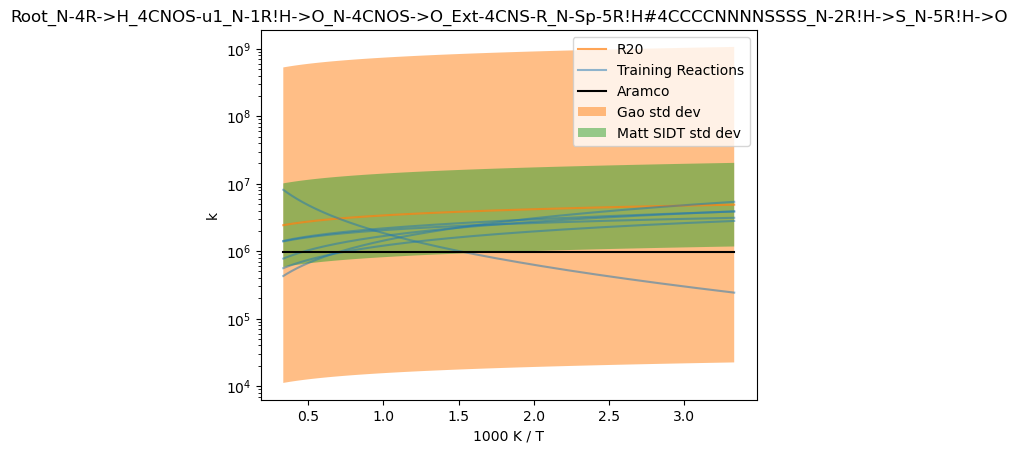

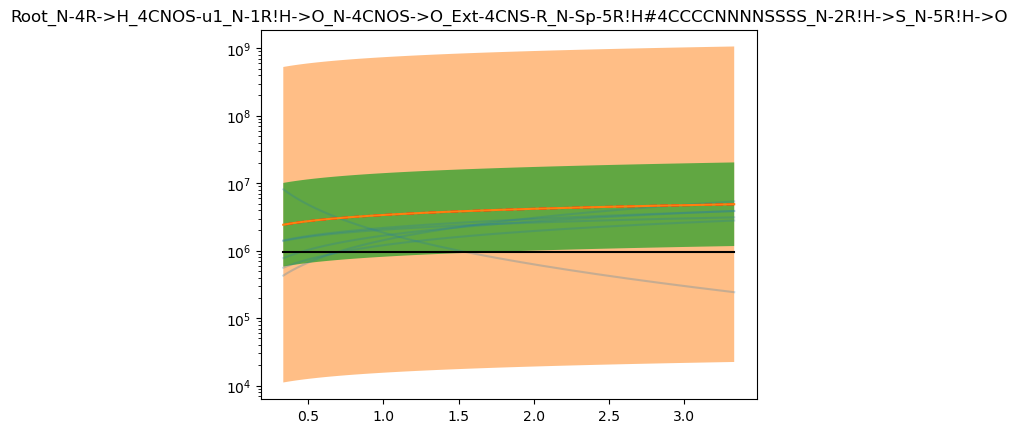

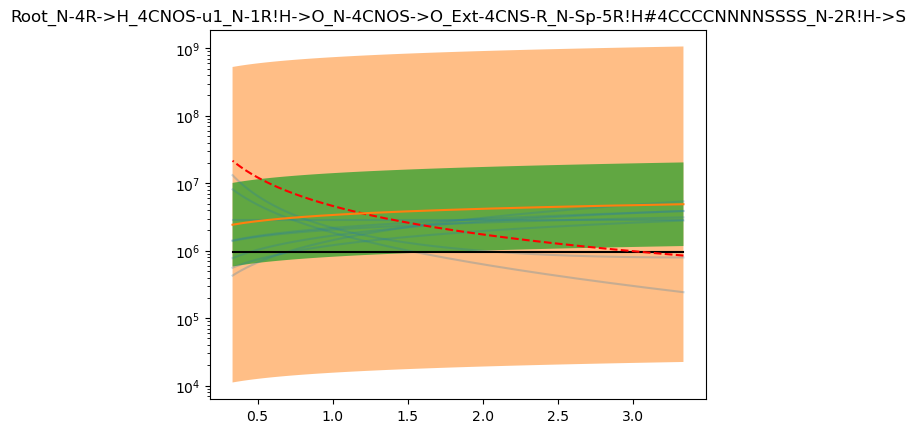

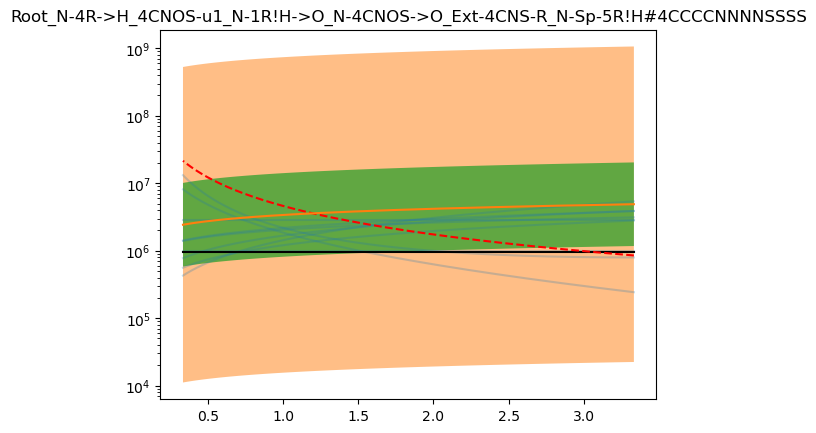

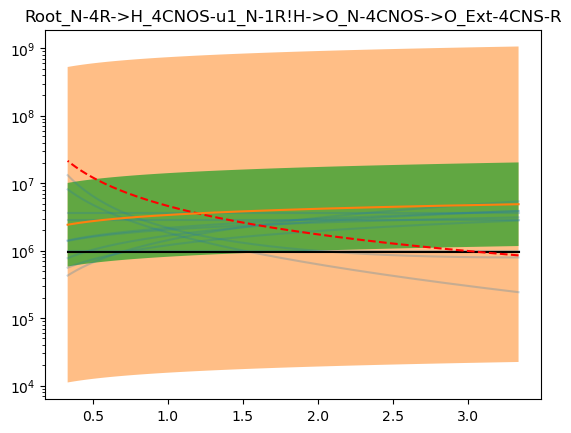

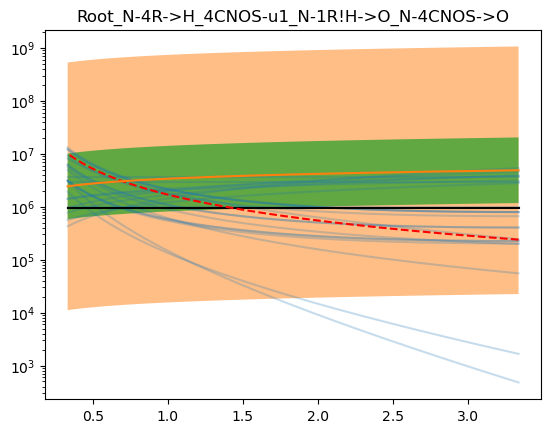

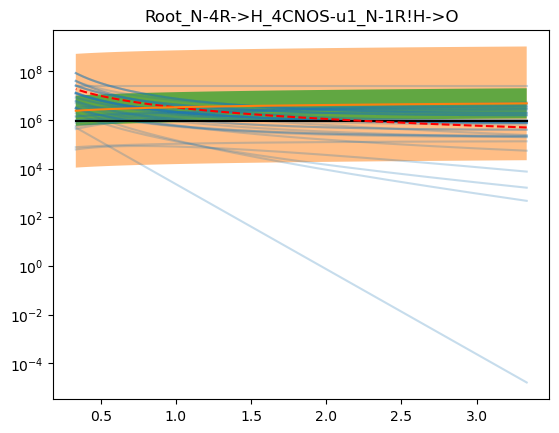

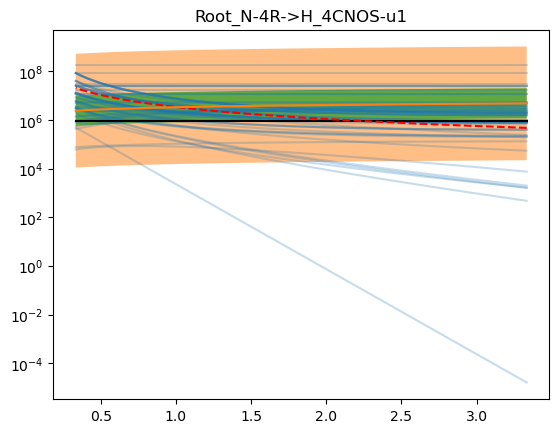

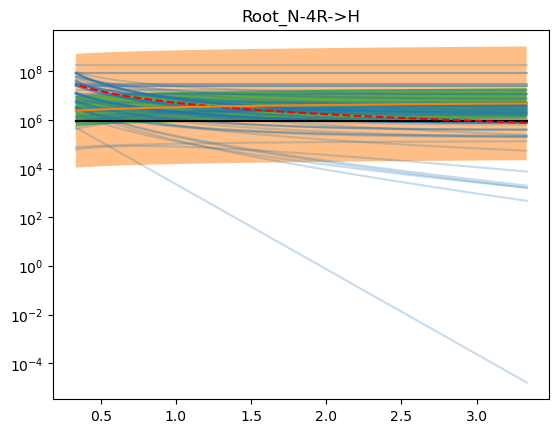

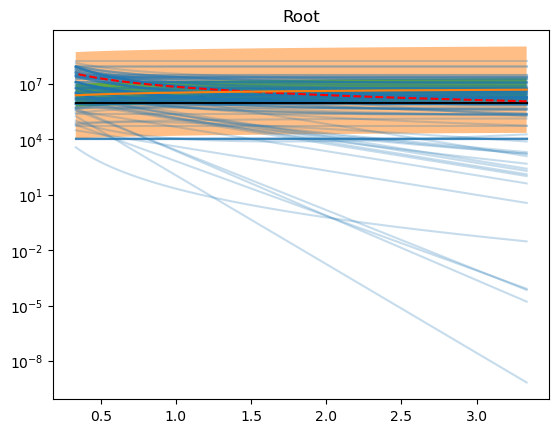

In [85]:
# Plot BM node variance uncertainty, Gao uncertainty, 
# aramco equation?
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# for i in range(len(uncertainty.reaction_list)):
for i in [20]:

    # Plot kinetics
    Tref = 1000.0
    T = np.linspace(300, 3000, 1001)
    P = 101325
    k = np.zeros(len(T))
    plt.clf()
    for j in range(0, len(T)):
        k[j] = uncertainty.reaction_list[i].get_rate_coefficient(T[j])
    plt.plot(1000.0 / T, k, label=f'R{i}', color=colors[1], alpha=0.7)

    
    gao_sigma_lnk = uncertainty.kinetic_input_uncertainties[i]
    gao_sigma_k = np.exp(gao_sigma_lnk)


    # Plot node std dev
    plt.fill_between(1000.0 / T, k, k * gao_sigma_k, alpha=0.5, color=colors[1], edgecolor=None, label='Gao std dev')
    plt.fill_between(1000.0 / T, k / gao_sigma_k, k, alpha=0.5, color=colors[1], edgecolor=None)

    # plot Matt's uncertainty if it's a BM tree node...
    if 'Rate Rules' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys() and \
            uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['node']:
        family = uncertainty.reaction_list[i].family
        if family != 'Intra_R_Add_Endocyclic' and family != 'Intra_R_Add_Exocyclic':
            node = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['node']
            rxns = auto_gen_families[f'{family}_rxn_map'][node]
#             sigma_lnk = get_node_std(rxns, family)
            if len(rxns) == 1:
                print('NO SIDT EST')
            sigma_lnk = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['node_std_dev']
            
            if np.isnan(sigma_lnk):
                continue
            sigma_k = np.exp(sigma_lnk)
            plt.fill_between(1000.0 / T, k, k * sigma_k, alpha=0.5, color=colors[2], edgecolor=None, label='Matt SIDT std dev')
            plt.fill_between(1000.0 / T, k / sigma_k, k, alpha=0.5, color=colors[2], edgecolor=None)
        
        
            # also plot training reactions
            for z in range(len(auto_gen_families[f'{family}_rxn_map'][node])):
                rxn = auto_gen_families[f'{family}_rxn_map'][node][z]
                k = np.zeros(len(T))
                for j in range(0, len(T)):
                    assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
                    k[j] = rxn.get_rate_coefficient(T[j])
                if z == 0:
                    plt.plot(1000.0 / T, k, label='Training Reactions', color=colors[0], alpha=0.5)
                else:
                    plt.plot(1000.0 / T, k, label='_nolegend_', color=colors[0], alpha=0.5)
                plt.yscale('log')
        
    print(i)
    display(uncertainty.reaction_list[i])
    print(uncertainty.kinetic_input_uncertainties[i])
    print(uncertainty.reaction_list[i].kinetics)
        
    # look for Aramco version
    a = get_aramco_rxn_i(uncertainty.reaction_list[i])
    P = 101325
    if a >= 0:
        # reverse the reaction if need be:
        rxnA = reaction_listA[a]
        if not reactions_in_same_direction(uncertainty.reaction_list[i], rxnA):
            print('REVERSING')
            rxnA = reaction_listA[a].generate_reverse_rate_coefficient()
                                           
        
        k = np.zeros(len(T))
        for j in range(0, len(T)):
            k[j] = rxnA.get_rate_coefficient(T[j], P)
        plt.plot(1000.0 / T, k, label=f'Aramco', color='black')
    
    
    
#     plt.title(f'U log_10 k = {np.round(np.log10(gao_sigma_k), 3)}')
    plt.title(node)
    plt.xlabel ('1000 K / T')
    plt.ylabel('k')
    plt.yscale('log')
    plt.legend()
    plt.show()
    print()
    print()
    
    
    # plot parent nodes
    if 'Rate Rules' in uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]].keys() and \
            uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['node']:
        family = uncertainty.reaction_list[i].family
        if family != 'Intra_R_Add_Endocyclic' and family != 'Intra_R_Add_Exocyclic':
#             parent_node = uncertainty.database.kinetics.families[family].groups.entries[node].parent.label
            parent_node = node
            while parent_node is not None:
                Tref = 1000.0
                kineticsBM = uncertainty.database.kinetics.families[family].rules.entries[parent_node][0].data
                kinetics = kineticsBM.to_arrhenius(uncertainty.reaction_list[i].get_enthalpy_of_reaction(Tref))
                
                T = np.linspace(300, 3000, 1001)
                P = 101325
                k = np.zeros(len(T))
                official_k = np.zeros(len(T))
                plt.clf()
                
                for j in range(0, len(T)):
                    k[j] = kinetics.get_rate_coefficient(T[j]) * uncertainty.reaction_list[i].degeneracy
#                     k[j] = kineticsBM.to_arrhenius(uncertainty.reaction_list[i].get_enthalpy_of_reaction(Tref)).get_rate_coefficient(T[j])
                plt.plot(1000.0 / T, k, label=f'R{i}-node', color='red', linestyle='dashed', alpha=1.0, zorder=10)
                
                for j in range(0, len(T)):
#                     k[j] = uncertainty.database.kinetics.families[family].rules.entries[parent_node][0].data
                    k[j] = uncertainty.reaction_list[i].get_rate_coefficient(T[j])
                    official_k[j] = uncertainty.reaction_list[i].get_rate_coefficient(T[j])
                plt.plot(1000.0 / T, k, label=f'R{i}', color=colors[1], alpha=1.0, zorder=10)
        

                gao_sigma_lnk = uncertainty.kinetic_input_uncertainties[i]
                gao_sigma_k = np.exp(gao_sigma_lnk)


                # Plot node std dev
                plt.fill_between(1000.0 / T, k, k * gao_sigma_k, alpha=0.5, color=colors[1], edgecolor=None, label='Gao std dev')
                plt.fill_between(1000.0 / T, k / gao_sigma_k, k, alpha=0.5, color=colors[1], edgecolor=None)
                
                
                rxns = auto_gen_families[f'{family}_rxn_map'][parent_node]
                for z in range(len(rxns)):
                    rxn = auto_gen_families[f'{family}_rxn_map'][parent_node][z]
                    k = np.zeros(len(T))
                    for j in range(0, len(T)):
                        assert type(rxn.kinetics) == rmgpy.kinetics.arrhenius.Arrhenius
                        k[j] = rxn.get_rate_coefficient(T[j])
                    if z == 0:
                        plt.plot(1000.0 / T, k, label='Training Reactions', color=colors[0], alpha=0.25)
                    else:
                        plt.plot(1000.0 / T, k, label='_nolegend_', color=colors[0], alpha=0.25)
                    plt.yscale('log')
                    
                
                if len(rxns) == 1:
                    print('NO SIDT EST')
                sigma_lnk = uncertainty.reaction_sources_dict[uncertainty.reaction_list[i]]['Rate Rules'][1]['node_std_dev']

                if np.isnan(sigma_lnk):
                    continue
                sigma_k = np.exp(sigma_lnk)
                plt.fill_between(1000.0 / T, official_k, official_k * sigma_k, alpha=0.75, color=colors[2], edgecolor=None, label='Matt SIDT std dev')
                plt.fill_between(1000.0 / T, official_k / sigma_k, official_k, alpha=0.75, color=colors[2], edgecolor=None)
        
                
                    
                a = get_aramco_rxn_i(uncertainty.reaction_list[i])
                P = 101325
                if a >= 0:
                    # reverse the reaction if need be:
                    rxnA = reaction_listA[a]
                    if not reactions_in_same_direction(uncertainty.reaction_list[i], rxnA):
                        print('REVERSING')
                        rxnA = reaction_listA[a].generate_reverse_rate_coefficient()


                    k = np.zeros(len(T))
                    for j in range(0, len(T)):
                        k[j] = rxnA.get_rate_coefficient(T[j], P)
                    plt.plot(1000.0 / T, k, label=f'Aramco', color='black')
                    
                    
                plt.title(parent_node)
                plt.show()
                
                parent_entry = uncertainty.database.kinetics.families[family].groups.entries[parent_node].parent
                if parent_entry:
                    parent_node = parent_entry.label
                else:
                    parent_node = None


                    


# debug difference in kinetics from BM vs chemkin

In [79]:
# for i in range(len(uncertainty.reaction_list)):
for i in [20]:
    if 'Root' in uncertainty.reaction_list[i].kinetics.comment:
        family = uncertainty.reaction_list[i].family
        exact, source = uncertainty.database.kinetics.families[family].extract_source_from_comments(uncertainty.reaction_list[i])
        if not exact:
            node = source[1]['node']
            print(i, uncertainty.reaction_list[i].kinetics.comment, node)
            print()

20 Estimated from node Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O
Multiplied by reaction path degeneracy 2.0 Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S_N-5R!H->O



In [89]:
get_aramco_rxn_i(uncertainty.reaction_list[20])

280

In [90]:
uncertainty.reaction_list[20].family

'Disproportionation'

In [32]:
uncertainty.database.kinetics.families[family].groups.entries[node].parent.label

'Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S'

In [34]:
parent_node

'Root_N-4R->H_4CNOS-u1_N-1R!H->O_N-4CNOS->O_Ext-4CNS-R_N-Sp-5R!H#4CCCCNNNNSSSS_N-2R!H->S'

In [49]:
uncertainty.database.kinetics.families[family].rules.entries[node][0].data.get_rate_coefficient(uncertainty.reaction_list[i].get_enthalpy_of_reaction(1000))

nan

In [52]:
uncertainty.reaction_list[i].get_enthalpy_of_reaction(1000)

-319930.23708630877

In [13]:
uncertainty.reaction_list[21]

In [14]:
uncertainty.kinetic_input_uncertainties[21]

13.809177173446296

In [15]:
uncertainty.reaction_list[21].kinetics

Arrhenius(A=(7.90318e+18,'s^-1'), n=-1.971, Ea=(9.786,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root
Multiplied by reaction path degeneracy 2.0""")

In [16]:
uncertainty.reaction_list[21].family

'Singlet_Carbene_Intra_Disproportionation'

In [33]:
get_node_std(auto_gen_families['Singlet_Carbene_Intra_Disproportionation_rxn_map']['Root'], 'Singlet_Carbene_Intra_Disproportionation')


19.271914004326693

In [26]:
uncertainty.database.kinetics.families['Singlet_Carbene_Intra_Disproportionation'].rules.entries['Root'][0].data

ArrheniusBM(A=(3.95159e+18,'s^-1'), n=-1.97082, w0=(539000,'J/mol'), E0=(112289,'J/mol'), Tmin=(300,'K'), Tmax=(1500,'K'), uncertainty=RateUncertainty(mu=-0.8305765209480382, var=17.041866923497537, Tref=1000.0, N=4, data_mean=0.0, correlation='Root',), comment="""BM rule fitted to 4 training reactions at node Root
    Total Standard Deviation in ln(k): 10.36278215827023""")

In [32]:
len(auto_gen_families['Singlet_Carbene_Intra_Disproportionation_rxn_map']['Root'])

4

In [39]:
uncertainty.reaction_list[19].kinetics

Arrhenius(A=(4.8e+08,'cm^3/(mol*s)'), n=1.5, Ea=(0,'kcal/mol'), T0=(1,'K'), comment="""Estimated from node Root_4R->H_N-Sp-2R!H-1R!H_1R!H->C
Multiplied by reaction path degeneracy 2.0""")

In [40]:
uncertainty.kinetic_input_uncertainties[19]

13.593787746348928

In [41]:
uncertainty.reaction_sources_dict[uncertainty.reaction_list[19]]

{'Rate Rules': ['Disproportionation',
  {'template': '',
   'degeneracy': 2.0,
   'exact': False,
   'rules': '',
   'training': '',
   'node': 'Root_4R->H_N-Sp-2R!H-1R!H_1R!H->C',
   'node_std_dev': 11.540182761524994,
   'node_n_train': 1}]}

In [ ]:
get_aramco_rxn_i(uncertainty.reaction_list[0])

In [ ]:
reaction_listA[188].get_rate_coefficient(1000, 101325)

In [ ]:
type(reaction_list[1].kinetics)

In [ ]:
uncertainty.reaction_sources_dict[uncertainty.reaction_list[0]]['Rate Rules'][1]['node']

In [ ]:
reaction_list[0].kinetics

In [ ]:
# For each BM node, show reaction with uncertainty and training reaction...

# then also do this for catalysis




In [ ]:
# pick some example reactions to estimate

for i in range(len(reaction_list)):
    if not hasattr(reaction_list[i], 'family'):
        continue
        
        
    z = 80
print(reaction_list[z].family)
display(reaction_list[z])
print(reaction_list[z].kinetics)

my_rxn = copy.deepcopy(reaction_list[z])

print(my_rxn.reactants[0].molecule[0].get_all_labeled_atoms())
print(my_rxn.reactants[1].molecule[0].get_all_labeled_atoms())
print()

database.kinetics.families[reaction_list[z].family].add_atom_labels_for_reaction(my_rxn)

print(my_rxn.reactants[0].molecule[0].get_all_labeled_atoms())
print(my_rxn.reactants[1].molecule[0].get_all_labeled_atoms())
print()

template_labels = database.kinetics.families[my_rxn.family].get_reaction_template_labels(my_rxn)
print(template_labels)
template = database.kinetics.families[my_rxn.family].retrieve_template(template_labels)
print(template)
print()

kinetics = database.kinetics.families[my_rxn.family].get_kinetics_for_template(template, degeneracy=my_rxn.degeneracy)[0]
print(kinetics)

plot_kinetics([reaction_list[z], my_rxn], labels=['Original', 'refitted'])
